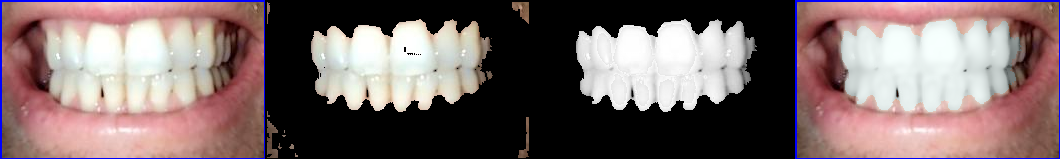

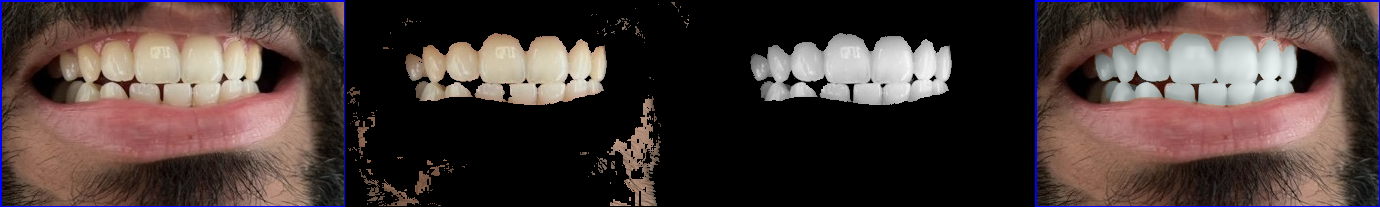

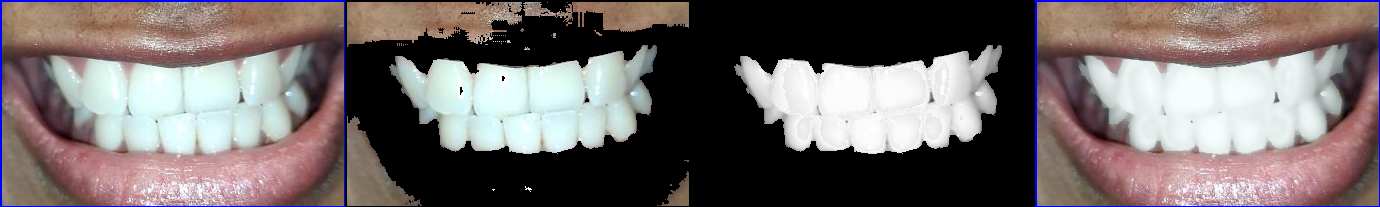

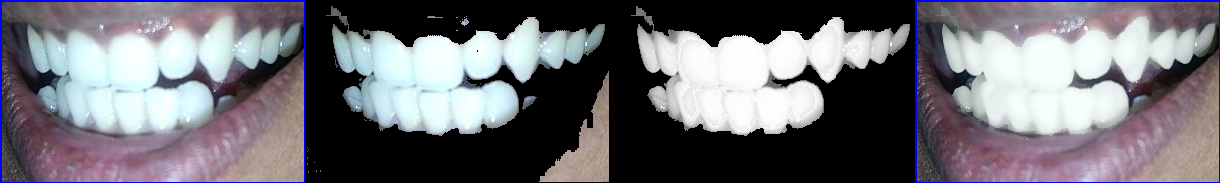

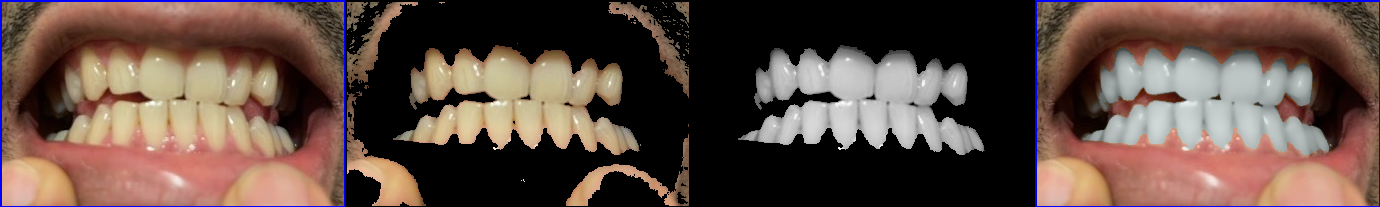

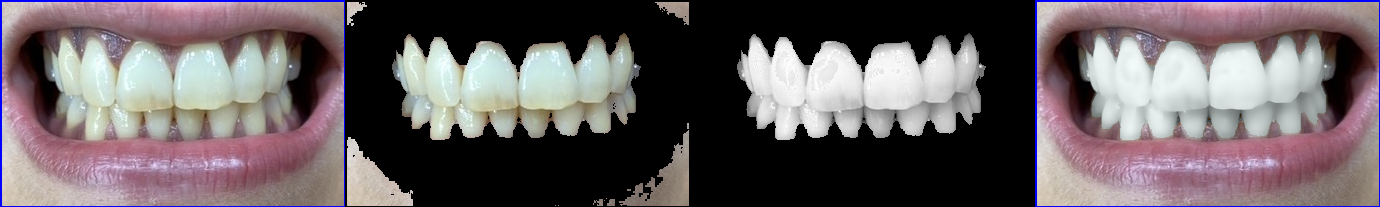

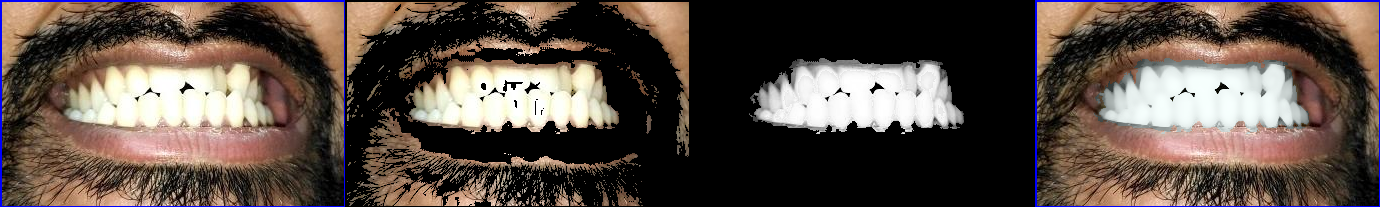

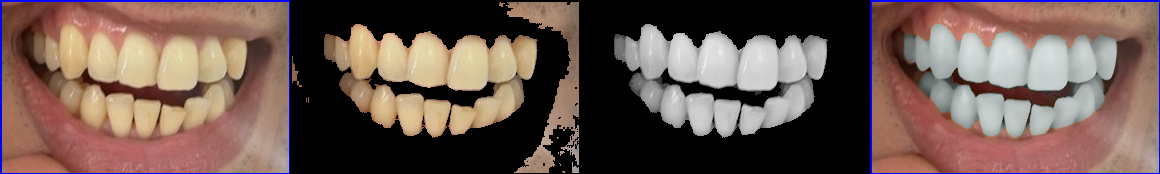

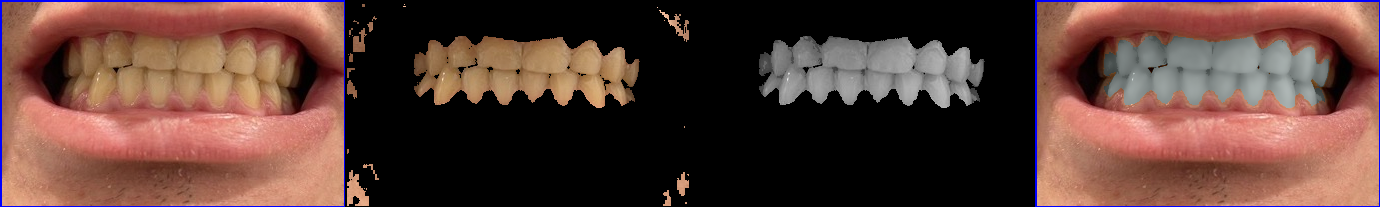

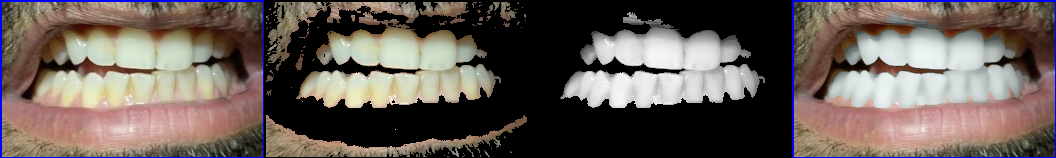

In [4]:
import os
import sys
import argparse
import cv2
import dlib
import numpy as np
from skimage import io
from PIL import Image
from scipy.spatial import distance
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

images = ["98131650599781345.jpeg","97281656150603693.jpeg","92941642517882289.jpeg","90771650991876562.jpeg","90491644539985109.jpeg","81471647469196045.jpeg","72481654091972855.jpeg","66981650755750147.jpeg","52001650756788238.jpeg","80841652332768762.jpeg"]

# REQUIRES PATH FOR "shape_predictor_68_face_landmarks.dat" FILE
predictor = dlib.shape_predictor("/content/gdrive/MyDrive/predictor/shape_predictor_68_face_landmarks.dat")

NoneType = type(None)

"machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images."
"Requires .xml file to perform cascade operation"
mouth_cascade = cv2.CascadeClassifier("/content/gdrive/MyDrive/tooth_img/Mouth.xml")

def get_largest_contour(contours):
    """
    In the given images, there may be various sections picked up by the detection algorithm,
    this chooses the largest section to correct, as it is most likely the actual red eye
    """
    largest_contour_area = 0
    largest_contour = None

    for contour in contours:
        contour_area = cv2.contourArea(contour)

        if contour_area > largest_contour_area:
            largest_contour_area = contour_area
            largest_contour = contour

    return largest_contour

def get_largest_mouth_region(mouths):
	"""
	Gets the largest mouth region on a zoomed in picture of a face when there
	may be multiple possible mouths selected by the haarcascade
	"""
	largest_region = 0
	largest_mouth = None

	for mouth in mouths:
		mx, my, mw, mh = mouth
		area = (mx + mw) * (my + mh)
  
		if area > largest_region:
			largest_region = area
			largest_mouth = mouth

	return largest_mouth


def first_layer_segmentation(mouth_section):

  teeth_image = cv2.cvtColor(mouth_section, cv2.COLOR_RGB2HSV)

  "first color mask for lips"
  lower = np.array([110, 40, 0])
  upper = np.array([255,201,255])
  mask = cv2.inRange(teeth_image, lower, upper)
  imageResult = cv2.bitwise_and(teeth_image, teeth_image, mask=mask)

  im_hsv = imageResult.copy()
  h, s, v = cv2.split(im_hsv)
  
  for x in range(v.shape[0]):
    for y in range(v.shape[1]):
      if v[x][y] == 0:
        v[x][y] = 255
      elif v[x][y] != 0 and v[x][y] < 255:
        v[x][y] = 0
  
  img_lip_mask = cv2.merge((h, s, v))
  img_lip_mask = cv2.cvtColor(img_lip_mask, cv2.COLOR_HSV2RGB)

  img_masked = cv2.cvtColor(img_lip_mask, cv2.COLOR_RGB2GRAY)

  img_c_mask = cv2.bitwise_and(mouth_section, mouth_section, mask=img_masked)
  
  image_hsv = cv2.cvtColor(img_c_mask, cv2.COLOR_RGB2HSV)
  mask_t = cv2.inRange(image_hsv, np.array([0, 0, 95]), np.array([110, 160, 255]))

  imageR = cv2.bitwise_and(image_hsv, image_hsv, mask=mask_t)
  imageR = cv2.cvtColor(imageR, cv2.COLOR_HSV2RGB)

  return imageR

def second_layer_segmentation(first_layer_image):

  imr_g = cv2.cvtColor(first_layer_image, cv2.COLOR_RGB2GRAY)

  contours, _ = cv2.findContours(imr_g, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  mouth_contour = get_largest_contour(contours)
  
  mask_f_t = np.zeros(mouth_section.shape,np.uint8)
  cv2.drawContours(mask_f_t,[mouth_contour],0,(255,255,255),-1)

  mask_f_t = cv2.cvtColor(mask_f_t, cv2.COLOR_RGB2GRAY)

  img_f = cv2.bitwise_and(mouth_section, mouth_section, mask=mask_f_t)

  img_g = cv2.cvtColor(img_f, cv2.COLOR_RGB2GRAY)

  for x in range(img_g.shape[0]):
    for y in range(img_g.shape[1]):
      if img_g[x][y] < 50:
        img_g[x][y] = 0
      elif img_g[x][y] > 80 and img_g[x][y] < 230:
        img_g[x][y] += 20

  img_g_rgb = cv2.cvtColor(img_g.copy(), cv2.COLOR_GRAY2RGB)

  return img_g_rgb


def whitened_tooth(second_layer_image, mouth_section):

  img_o = second_layer_image.copy()
  img_o_v = cv2.cvtColor(img_o, cv2.COLOR_RGB2LAB)
  l, a, b = cv2.split(img_o_v)

  img_a = second_layer_image.copy()

  r, g, b = cv2.split(img_a)
  for x in range(img_a.shape[0]):
    for y in range(img_a.shape[1]):
      r[x][y] = 216
      g[x][y] = 216
      b[x][y] = 207
  final_a_img = cv2.merge((r,g,b))

  final_v_img = cv2.cvtColor(final_a_img.copy(), cv2.COLOR_RGB2LAB)
  _l, _a, _b = cv2.split(final_v_img)

  for x in range(final_v_img.shape[0]):
    for y in range(final_v_img.shape[1]):
      _l[x][y] = l[x][y]
  
  final_result = cv2.merge((_l, _a, _b))

  final_rgb = cv2.cvtColor(final_result.copy(), cv2.COLOR_LAB2RGB)

  blur =cv2.bilateralFilter(final_rgb,9,75,75)
  rr, gg, bb = cv2.split(blur)

  merge_img = mouth_section.copy()
  r_, g_, b_ = cv2.split(merge_img)
  
  for x in range(merge_img.shape[0]):
    for y in range(merge_img.shape[1]):
      if l[x][y] != 0:
        r_[x][y] = rr[x][y]
        g_[x][y] = gg[x][y]
        b_[x][y] = bb[x][y]
  final_m_img = cv2.merge((r_,g_,b_))

  return final_m_img


for i in images:
  input_image = cv2.imread(i)
  mouths = mouth_cascade.detectMultiScale(input_image, 1.3, 5)
  
  mouth = get_largest_mouth_region(mouths)

  if type(mouth) != NoneType:
    mx, my, mw, mh = mouth
    cv2.rectangle(input_image, (mx, my), (mx + mw, my + mh), (255, 0, 0), 2)

    mouth_section = input_image[my:my + mh, mx:mx + mw]
  else:
    mouth_section = input_image.copy()

  first_segment_image = first_layer_segmentation(mouth_section)

  second_segment_image = second_layer_segmentation(first_segment_image)

  whitened_tooth_image = whitened_tooth(second_segment_image, mouth_section)

  """Merge all iages into one frame"""
  Horizontal_frame = np.concatenate((mouth_section, first_segment_image, second_segment_image, whitened_tooth_image), axis=1)

  cv2_imshow(Horizontal_frame)
  
  
  
  

 